In [1]:
import numpy as np
from sklearn import svm
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [2]:
def auc_OC_SVM(dataset,idx):
    '''
    OC-SVM returning AUC measure of the test dataset
    --------
    Args :
        dataset : Dataset for one-class classification "Handwritten" or "FMNIST"
        idx : Index of the dataset to be trained/tested for one-class classification
    --------
    Return :
        auc_measure : AUC measure of the test dataset
    '''

    vector_train = []
    vector_test_pos = []
    vector_test_neg = []
    neg_list = list(range(10))
    neg_list.remove(idx)

    if dataset == "Handwritten":
        digits = load_digits()
        digit_pos = digits.data[np.where(digits.target == idx)]

        for i in range(100):
            vector_train.append(np.array(digit_pos[i]))
        for i in range(100,170):
            vector_test_pos.append(np.array(digit_pos[i]))
        for idx_neg in neg_list:
            digit_neg = digits.data[np.where(digits.target == idx_neg)]
            for i in range(70):
                vector_test_neg.append(np.array(digit_neg[i]))

        vector_train= np.array(vector_train)
        vector_test_pos= np.array(vector_test_pos)
        vector_test_neg= np.array(vector_test_neg)

        perm_pos = np.random.permutation(70)
        perm_neg = np.random.permutation(630)
        vector_val_pos = vector_test_pos[perm_pos[:7]]
        vector_val_neg = vector_test_neg[perm_neg[:63]]
        
    elif dataset == "MNIST":
        mnist = tf.keras.datasets.mnist
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
        digit_pos = x_train[np.where(y_train == idx)]

        for i in range(100):
            vector = cv2.resize(digit_pos[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
            vector_train.append(vector)
        for i in range(100,200):
            vector = cv2.resize(digit_pos[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
            vector_test_pos.append(vector)
        for idx_neg in neg_list:
            digit_neg = x_train[np.where(y_train == idx_neg)]
            for i in range(100):
                vector = cv2.resize(digit_neg[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
                vector_test_neg.append(vector)

        vector_train= np.array(vector_train)
        vector_test_pos= np.array(vector_test_pos)
        vector_test_neg= np.array(vector_test_neg)
        perm_pos = np.random.permutation(100)
        perm_neg = np.random.permutation(900)
        vector_val_pos = vector_test_pos[perm_pos[:10]]
        vector_val_neg = vector_test_neg[perm_neg[:90]]

    elif dataset == "FMNIST":
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
        x_train, x_test = x_train / 255.0, x_test / 255.0
        digit_pos = x_train[np.where(y_train == idx)]

        for i in range(100):
            vector = cv2.resize(digit_pos[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
            vector_train.append(vector)
        for i in range(100,200):
            vector = cv2.resize(digit_pos[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
            vector_test_pos.append(vector)
        for idx_neg in neg_list:
            digit_neg = x_train[np.where(y_train == idx_neg)]
            for i in range(100):
                vector = cv2.resize(digit_neg[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
                vector_test_neg.append(vector)

        vector_train= np.array(vector_train)
        vector_test_pos= np.array(vector_test_pos)
        vector_test_neg= np.array(vector_test_neg)
        perm_pos = np.random.permutation(100)
        perm_neg = np.random.permutation(900)
        vector_val_pos = vector_test_pos[perm_pos[:10]]
        vector_val_neg = vector_test_neg[perm_neg[:90]]


    else:
        raise ValueError(
            "Handwritten digit and Fashion MNIST datasets are supported"
        )

    auc_val = 0.0
    gamma_opt = 0.0
    nu_opt = 0.0
    for gamma in np.logspace(-10, -1, num=10, base=2):
        for nu in [0.1, 0.01]:
            clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
            clf.fit(vector_train)
            y_pred_train = clf.predict(vector_train)
            y_pred_val_pos = clf.predict(vector_val_pos)
            y_pred_val_neg = clf.predict(vector_val_neg)

            Z_val_pos = clf.decision_function(vector_val_pos)
            Z_val_neg = clf.decision_function(vector_val_neg)

            y_true = np.array([1]*len(Z_val_pos)+[0]*len(Z_val_neg))
            y_score = np.r_[Z_val_pos,Z_val_neg]
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_new = auc(fpr,tpr)
            if auc_new > auc_val :
                auc_val = auc_new
                gamma_opt = gamma
                nu_opt = nu

    clf = svm.OneClassSVM(nu=nu_opt, kernel="rbf", gamma=gamma_opt)
    clf.fit(vector_train)
    y_pred_train = clf.predict(vector_train)
    y_pred_test_pos = clf.predict(vector_test_pos)
    y_pred_test_neg = clf.predict(vector_test_neg)

    Z_test_pos = clf.decision_function(vector_test_pos)
    Z_test_neg = clf.decision_function(vector_test_neg)

    y_true = np.array([1]*len(Z_test_pos)+[0]*len(Z_test_neg))
    y_score = np.r_[Z_test_pos,Z_test_neg]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_measure = auc(fpr,tpr)

    return auc_measure

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

idx = 0
vector_train = []
vector_test_pos = []
vector_test_neg = []
neg_list = list(range(10))
neg_list.remove(idx)

x_train_pos = x_train[np.where(y_train == idx)]
x_test_pos = x_test[np.where(y_test == idx)]

for i in range(100):
    vector = cv2.resize(x_train_pos[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
    vector_train.append(vector)
for i in range(100):
    vector = cv2.resize(x_test_pos[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
    vector_test_pos.append(vector)
for idx_neg in neg_list:
    x_test_neg = x_test[np.where(y_test == idx_neg)]
    for i in range(100):
        vector = cv2.resize(x_test_neg[i],dsize=(16, 16), interpolation=cv2.INTER_CUBIC).flatten()
        vector_test_neg.append(vector)
        
vector_train = np.array(vector_train)
vector_test_pos = np.array(vector_test_pos)
vector_test_neg = np.array(vector_test_neg)

perm_pos = np.random.permutation(100)
perm_neg = np.random.permutation(900)
vector_val_pos = vector_test_pos[perm_pos[:10]]
vector_val_neg = vector_test_neg[perm_neg[:90]]

In [4]:
auc_val = 0.0
gamma_opt = 0.0
nu_opt = 0.0
for gamma in np.logspace(-10, -1, num=10, base=2):
    for nu in [0.1, 0.01]:
        clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
        clf.fit(vector_train)
        y_pred_train = clf.predict(vector_train)
        y_pred_val_pos = clf.predict(vector_val_pos)
        y_pred_val_neg = clf.predict(vector_val_neg)

        Z_val_pos = clf.decision_function(vector_val_pos)
        Z_val_neg = clf.decision_function(vector_val_neg)

        y_true = np.array([1]*len(Z_val_pos)+[0]*len(Z_val_neg))
        y_score = np.r_[Z_val_pos,Z_val_neg]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_new = auc(fpr,tpr)
        if auc_new > auc_val :
            auc_val = auc_new
            gamma_opt = gamma
            nu_opt = nu

clf = svm.OneClassSVM(nu=nu_opt, kernel="rbf", gamma=gamma_opt)
clf.fit(vector_train)
y_pred_train = clf.predict(vector_train)
y_pred_test_pos = clf.predict(vector_test_pos)
y_pred_test_neg = clf.predict(vector_test_neg)

Z_test_pos = clf.decision_function(vector_test_pos)
Z_test_neg = clf.decision_function(vector_test_neg)

y_true = np.array([1]*len(Z_test_pos)+[0]*len(Z_test_neg))
y_score = np.r_[Z_test_pos,Z_test_neg]
fpr, tpr, _ = roc_curve(y_true, y_score)
auc_measure = auc(fpr,tpr)

In [5]:
print(auc_measure)

0.9781777777777778


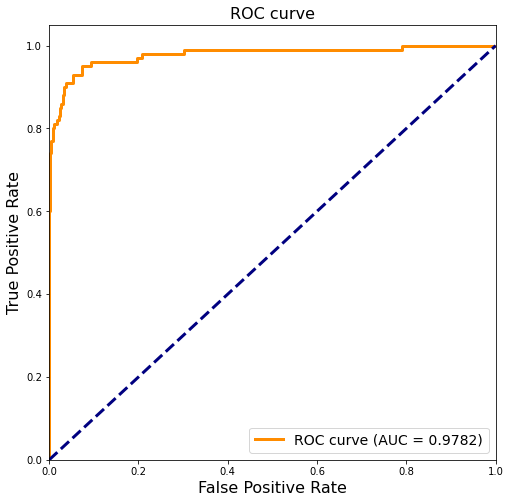

In [6]:
plt.figure(figsize = (8,8))
lw = 3
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (AUC = %0.4f)" % auc_measure,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate",fontsize=16)
plt.ylabel("True Positive Rate",fontsize=16)
plt.title("ROC curve",fontsize=16)
plt.legend(loc="lower right",fontsize=14)
plt.show()

In [7]:
idx_list = list(range(10))
auc_list = [auc_OC_SVM(dataset="MNIST",idx=idx) for idx in idx_list]
print(auc_list)

[0.9741555555555554, 0.9959666666666667, 0.8048444444444445, 0.9013666666666666, 0.9031444444444445, 0.8622444444444445, 0.9595555555555556, 0.9093555555555556, 0.8764, 0.8862888888888888]
